In [50]:
import numpy as np
from scipy.constants import Boltzmann as k
from numpy.typing import NDArray
from typing import List
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.ndimage import convolve, generate_binary_structure

In [424]:
N = 3
@nb.njit(parallel=True)
def generate_lattice(L: int, p: float = 0.5) -> np.ndarray:
    init_lattice = np.empty((L, L), dtype=np.float32)
    for i in nb.prange(L):
        for j in range(L):
            # Generate a random number for each element
            random_value = np.random.random()
            if random_value >= p:
                init_lattice[i, j] = 1
            else:
                init_lattice[i, j] = -1
    return init_lattice

state = generate_lattice(25, 0.5)

In [425]:
print(state)

[[-1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.
  -1. -1.  1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.
  -1.  1.  1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.
  -1. -1. -1.  1.  1. -1. -1.]
 [-1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
   1.  1. -1.  1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.
   1. -1. -1. -1. -1.  1. -1.]
 [-1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1.
  -1. -1. -1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  -1.  1.  1. -1. -1. -1. -1.]
 [-1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.
  -1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.
  -1.  1. -1. -1.  1.  1. -1.]
 [-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  

In [168]:
def energy_naive(lattice: np.ndarray) -> int:
    H = 0
    for row in lattice:
        H += (np.sum(row[:-1] * row[1:]) + row[0]*row[-1])
    
    for col in lattice.T:
        H += (np.sum(col[:-1] * col[1:]) + col[0]*col[-1])

    return -2*H


In [169]:
def energy_conv(lattice: np.ndarray) -> int:
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode = "wrap")
    return arr.sum()

In [170]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Use the nopython mode for better performance
def energy_numba(lattice: np.ndarray) -> int:
    H = 0
    N = lattice.shape[0]
    M = lattice.shape[1]

    # Calculate horizontal interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            right_neighbor = (j + 1) % M  # Wrap around horizontally
            H += lattice[i, j] * lattice[i, right_neighbor]

    # Calculate vertical interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            down_neighbor = (i + 1) % N  # Wrap around vertically
            H += lattice[i, j] * lattice[down_neighbor, j]

    return -2 * H

In [171]:
import numba as nb
@jit(parallel=True)
def energy(lattice):
    N, M = lattice.shape  # Assuming a square lattice for simplicity
    H = 0.0
    
    # Loop over all elements to calculate horizontal and vertical interactions
    # Parallelize the outer loop
    for i in nb.prange(N):
        for j in range(M):
            right_neighbor = (j + 1) % M
            down_neighbor = (i + 1) % N
            
            # Periodic boundary conditions are handled by wrapping index
            H += lattice[i, j] * (lattice[i, right_neighbor] + lattice[down_neighbor, j])
    
    # Multiply by -2 as in the original specification
    return -2 * H

In [172]:
print(energy(state))

-4.0


In [173]:
print(energy_numba(state))

-4.0


In [174]:
print(energy_naive(state))

-4.0


In [175]:
print(energy_conv(state))

-4.0


In [176]:
def plot(lattice):
    plt.imshow(lattice, cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000']))

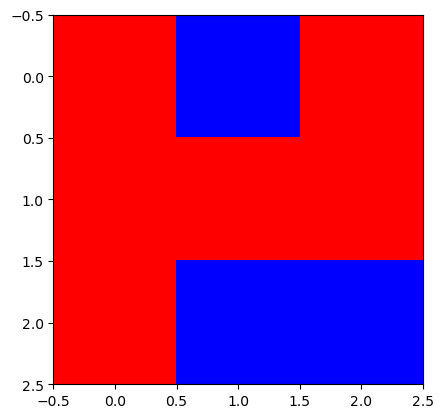

In [177]:
plot(state)

In [178]:
def delta_energy(initial_lattice: np.ndarray, spin_to_flip: tuple[int, int]) -> int:
    #Calculates E_new - E_old
    L = initial_lattice.shape[0]
    sum_of_neighbors = 0
    x,y = spin_to_flip[0], spin_to_flip[1]

    sum_of_neighbors += initial_lattice[(x + 1)%L, y]
    sum_of_neighbors += initial_lattice[(x - 1)%L, y]

    sum_of_neighbors += initial_lattice[x, (y + 1)%L]
    sum_of_neighbors += initial_lattice[x, (y - 1)%L]
     
    return 4 * sum_of_neighbors * initial_lattice[x, y]


In [426]:
print(delta_energy(state, [2,2]))

-0.0


In [165]:
new_state = state.copy()
new_state[4,4] = state[4,4] * -1

IndexError: index 4 is out of bounds for axis 0 with size 3

In [125]:
energy(state)

-64.0

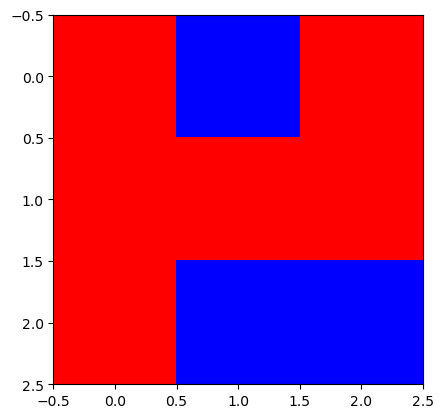

In [182]:
plot(state)

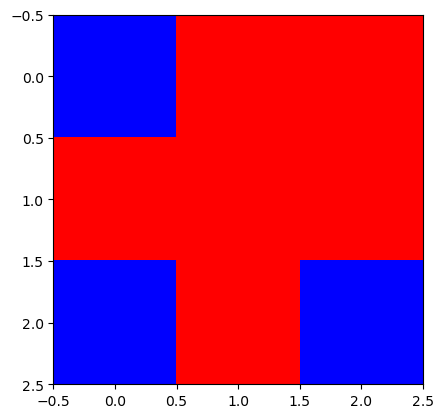

In [183]:
plot(new_state)

In [184]:
energy(new_state) - energy(state)

0.0

In [185]:
def flip_spin_in_lattice(lattice: np.ndarray, spin: tuple[int,int]) -> np.ndarray:
    #given a lattice l, return a new lattice l'
    spin_to_flip_x, spin_to_flip_y = spin
    new_lattice = lattice.copy()
    new_lattice[spin_to_flip_x, spin_to_flip_y] = lattice[spin_to_flip_x, spin_to_flip_y] * -1
    return new_lattice

In [429]:
energy(flip_spin_in_lattice(state, [5,4])) - energy(state)

8.0

In [430]:
delta_energy(state, [5,4])

8.0

In [188]:
def flip_random_spin(lattice: np.ndarray) -> tuple[int, int]:
    L = lattice.shape[0]
    return np.random.randint(0, L, size = (1,2))[0]

In [371]:
flip_random_spin(state)

array([0, 2])

In [288]:
def avg_magnetization(lattice: np.ndarray) -> float:
    return np.mean(lattice)

In [418]:
def metropolis_hasting_sampler(init_dist, beta, num_iters, sweep_size = 50):
    fixed_time_samples = []
    updated_samples = []
    sample = init_dist
    for i in range(num_iters):
        candidate_spin = flip_random_spin(sample)
        acceptance_prop = min(1, np.exp(-beta * delta_energy(sample, candidate_spin)))
        if (acceptance_prop > np.random.random()):
            sample = flip_spin_in_lattice(sample, candidate_spin)
            updated_samples.append(sample)
        if i % sweep_size == 0:
            fixed_time_samples.append(sample)
    return fixed_time_samples, updated_samples
            

In [446]:
mh_fixed_time_res, mh_updated_res = metropolis_hasting_sampler(generate_lattice(24, 0.5), 10, 1_000_000)
print(len(mh_fixed_time_res), len(mh_updated_res))

20000 2150


In [447]:
def turn_into_number(samples):
    res = []
    for sample in samples:
        flattened_sample = sample.flatten().tolist()
        binary_string = ''.join(str(1 if bit == 1 else 0) for bit in flattened_sample)
        res.append(int(binary_string, 2))
    return res


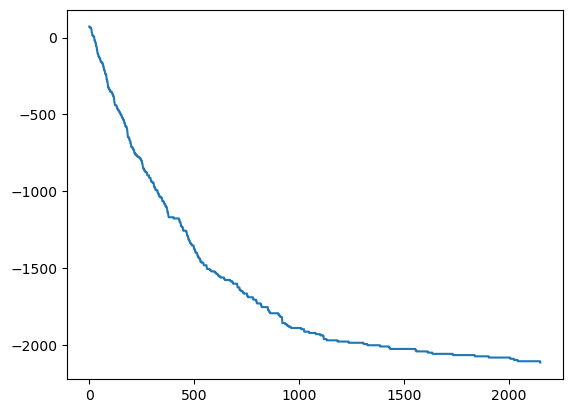

In [448]:
mh_res_energy = [energy(sample) for sample in mh_updated_res]
plt.plot(mh_res_energy)

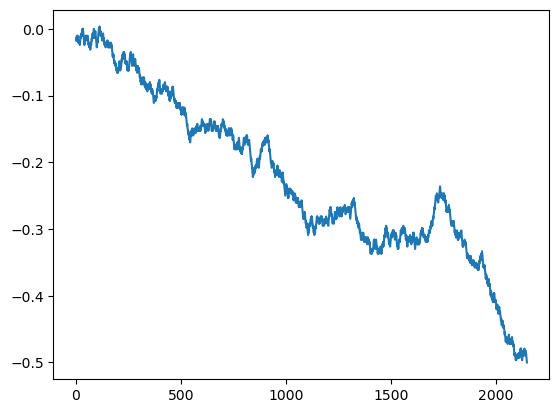

In [449]:
mh_res_magnetization = [avg_magnetization(sample) for sample in mh_updated_res]
plt.plot(mh_res_magnetization)

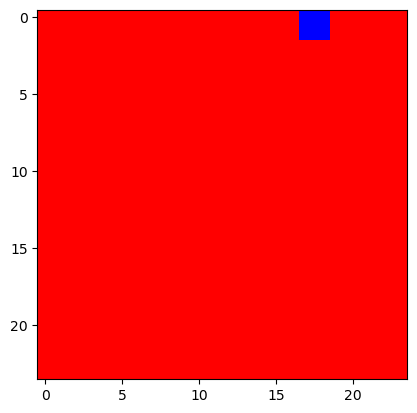

In [442]:
plot(mh_updated_res[-11])

In [ ]:
def heat_bath_update(lattice: nd_darray):
    